In [10]:
#各种import、加载SAM模型

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
from PIL import Image
from io import BytesIO

print("PyTorch version:", torch.__version__)
print("CUDA is available:", torch.cuda.is_available())

from segment_anything import sam_model_registry, SamPredictor
from toolfunc import *

sam_checkpoint = "sam_hq_vit_b.pth"
model_type = "vit_b"
device = "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

PyTorch version: 2.1.2+cu121
CUDA is available: True
<All keys matched successfully>


In [11]:
#可视化YOLO的Bounding Boxes、label、和confidence，保存在annotated_image.jpg

def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1) 
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)

def plot_bboxes(image, boxes, labels=[], colors=[], score=True, conf=None):

  if labels == []:
    labels = {0: u'__background__', 1: u'person', 2: u'bicycle',3: u'car', 4: u'motorcycle', 5: u'airplane', 6: u'bus', 7: u'train', 8: u'truck', 9: u'boat', 10: u'traffic light', 11: u'fire hydrant', 12: u'stop sign', 13: u'parking meter', 14: u'bench', 15: u'bird', 16: u'cat', 17: u'dog', 18: u'horse', 19: u'sheep', 20: u'cow', 21: u'elephant', 22: u'bear', 23: u'zebra', 24: u'giraffe', 25: u'backpack', 26: u'umbrella', 27: u'handbag', 28: u'tie', 29: u'suitcase', 30: u'frisbee', 31: u'skis', 32: u'snowboard', 33: u'sports ball', 34: u'kite', 35: u'baseball bat', 36: u'baseball glove', 37: u'skateboard', 38: u'surfboard', 39: u'tennis racket', 40: u'bottle', 41: u'wine glass', 42: u'cup', 43: u'fork', 44: u'knife', 45: u'spoon', 46: u'bowl', 47: u'banana', 48: u'apple', 49: u'sandwich', 50: u'orange', 51: u'broccoli', 52: u'carrot', 53: u'hot dog', 54: u'pizza', 55: u'donut', 56: u'cake', 57: u'chair', 58: u'couch', 59: u'potted plant', 60: u'bed', 61: u'dining table', 62: u'toilet', 63: u'tv', 64: u'laptop', 65: u'mouse', 66: u'remote', 67: u'keyboard', 68: u'cell phone', 69: u'microwave', 70: u'oven', 71: u'toaster', 72: u'sink', 73: u'refrigerator', 74: u'book', 75: u'clock', 76: u'vase', 77: u'scissors', 78: u'teddy bear', 79: u'hair drier', 80: u'toothbrush'}

  if colors == []:
    colors = [(89, 161, 197),(67, 161, 255),(19, 222, 24),(186, 55, 2),(167, 146, 11),(190, 76, 98),(130, 172, 179),(115, 209, 128),(204, 79, 135),(136, 126, 185),(209, 213, 45),(44, 52, 10),(101, 158, 121),(179, 124, 12),(25, 33, 189),(45, 115, 11),(73, 197, 184),(62, 225, 221),(32, 46, 52),(20, 165, 16),(54, 15, 57),(12, 150, 9),(10, 46, 99),(94, 89, 46),(48, 37, 106),(42, 10, 96),(7, 164, 128),(98, 213, 120),(40, 5, 219),(54, 25, 150),(251, 74, 172),(0, 236, 196),(21, 104, 190),(226, 74, 232),(120, 67, 25),(191, 106, 197),(8, 15, 134),(21, 2, 1),(142, 63, 109),(133, 148, 146),(187, 77, 253),(155, 22, 122),(218, 130, 77),(164, 102, 79),(43, 152, 125),(185, 124, 151),(95, 159, 238),(128, 89, 85),(228, 6, 60),(6, 41, 210),(11, 1, 133),(30, 96, 58),(230, 136, 109),(126, 45, 174),(164, 63, 165),(32, 111, 29),(232, 40, 70),(55, 31, 198),(148, 211, 129),(10, 186, 211),(181, 201, 94),(55, 35, 92),(129, 140, 233),(70, 250, 116),(61, 209, 152),(216, 21, 138),(100, 0, 176),(3, 42, 70),(151, 13, 44),(216, 102, 88),(125, 216, 93),(171, 236, 47),(253, 127, 103),(205, 137, 244),(193, 137, 224),(36, 152, 214),(17, 50, 238),(154, 165, 67),(114, 129, 60),(119, 24, 48),(73, 8, 110)]
  
  for box in boxes:

    if score :
      label = labels[int(box[-1])+1] + " " + str(round(100 * float(box[-2]),1)) + "%"
    else :
      label = labels[int(box[-1])+1]
    if conf :
      if box[-2] > conf:
        color = colors[int(box[-1])]
        box_label(image, box, label, color)
    else:
      color = colors[int(box[-1])]
      box_label(image, box, label, color)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  output_filename = "annotated_image.jpg"
  cv2.imwrite(output_filename, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
  print(f"Annotated image saved as {output_filename}")

In [12]:
#SAM的所有工作（加载图像、segmentation、可视化）
#和原本func的区别：input_box可以输入多个，每个分开做segmentation，然后所有的mask用逻辑或合成一个
#为了简单，只改动了最原始（没有滤波、没有转hsv等）的部分，其它的注释掉了

def func(image, input_point, input_label, input_box):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(point_coords=input_point,point_labels=input_label,box=input_box[0],multimask_output=False,hq_token_only= False)
    for i in input_box:
        mask, scores, logits = predictor.predict(point_coords=input_point,point_labels=input_label, box=i, multimask_output=False,hq_token_only= False)
        masks = np.logical_or(mask, masks)
    show_res(masks, scores, input_point, input_label, input_box, image)

def func2(image, input_point, input_label, input_box):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)
    mask, scores, logits = predictor.predict(point_coords=input_point,point_labels=input_label,box=None,multimask_output=False,hq_token_only= False)
    show_res(mask,scores,input_point, input_label, input_box, image)

In [13]:
#加载图像
# image = cv2.imread("assets/input_imgs/example8.png")
image = cv2.imread("assets/class.jpg")
#加载模型
model = YOLO("YOLOv8x.pt")
#直接将图像输入模型
results = model(image)
#获取关于bounding boxes的信息
boxes = np.array(results[0].to('cpu').boxes.data)

#输出YOLO的annotated_image.jpg，会影响segmentation结果，所以要做segmentation时，要注释掉（然后肯定要重新跑这个cell）
#plot_bboxes(image, results[0].boxes.data)
results


0: 480x640 20 persons, 1 handbag, 1 bottle, 4 chairs, 28.7ms
Speed: 3.8ms preprocess, 28.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

20
Score: 0.942


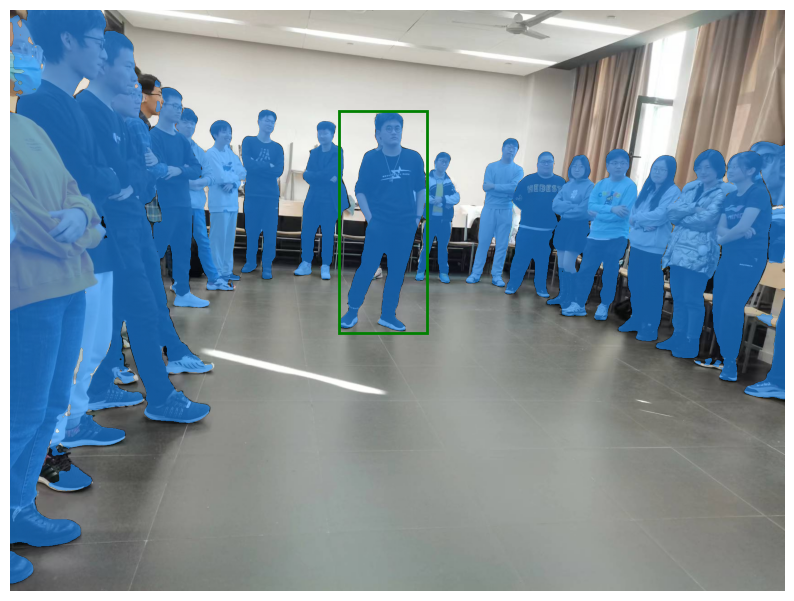

In [14]:
selected_boxes = []
for b in boxes:
    if b[5] == 0: #上面plot_boxes函数有YOLO的label，比如0是person, 2是car，如果全部都要，直接把这行注释掉
        selected_boxes.append(b[:-2]) #只保留boxes前4列的位置信息，后面的score和confidence没有用到
print(len(selected_boxes))

#如果要自动给所有选定的label/class都做segmentation，不用input_point，直接把下面的selected_boxes1改成selected_boxes
func(image, None, None, selected_boxes)


0: 480x640 22 persons, 4 bottles, 2 cups, 32 chairs, 4 laptops, 1 remote, 1 sink, 203.9ms
Speed: 10.0ms preprocess, 203.9ms inference, 9.5ms postprocess per image at shape (1, 3, 480, 640)
22
Score: 0.898


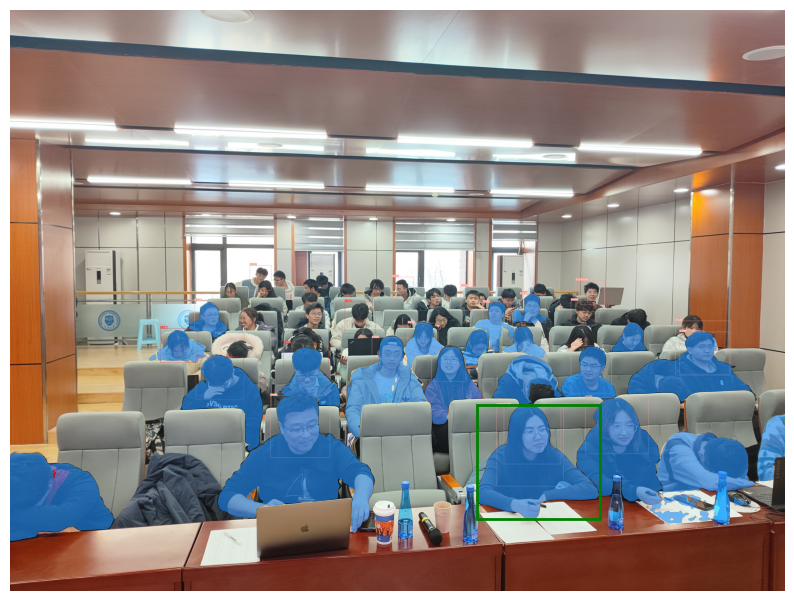

In [15]:
#直接将图像输入模型
image = cv2.imread("assets/class2.jpg")
results = model(image)
#获取关于bounding boxes的信息
boxes = np.array(results[0].to('cpu').boxes.data)

#输出YOLO的annotated_image.jpg，会影响segmentation结果，所以要做segmentation时，要注释掉（然后肯定要重新跑这个cell）
#plot_bboxes(image, results[0].boxes.data)
results
selected_boxes = []
for b in boxes:
    if b[5] == 0: #上面plot_boxes函数有YOLO的label，比如0是person, 2是car，如果全部都要，直接把这行注释掉
        selected_boxes.append(b[:-2]) #只保留boxes前4列的位置信息，后面的score和confidence没有用到
print(len(selected_boxes))

#如果要自动给所有选定的label/class都做segmentation，不用input_point，直接把下面的selected_boxes1改成selected_boxes
func(image, None, None, selected_boxes)

In [16]:
#标点选择目标（只点要做segmentation的，因为没有管input_label）
# input_point, input_label = getpos(image)
# func2(image, input_point, input_label, None)